# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет **систему компьютерного зрения** для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нашей **целью** является построить модель, которая по фотографии определит приблизительный возраст человека. 

В вашем распоряжении **набор фотографий людей с указанием возраста**.


**Этапы выполнения проекта**:
1.	Провести исследовательский анализ набора фотографий.
2.	Подготовить данные к обучению.
3.	Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

На начальном этапе стоит провести исследовательский анализ данных:
1. Посмотрим на размер выборки.
2. Построим график распределения возраста в выборке.
3. Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

Подгрузим необходимые библиотеки:

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

Прочитаем файл с метками возраста.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Выведем первые строчки таблицы.

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В таблице представлены названия фотографий и возраст людей на этих фотографиях.

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего представлена 7591 фотография.

Построим распределение представленных в датасете фотографий по возрастам.

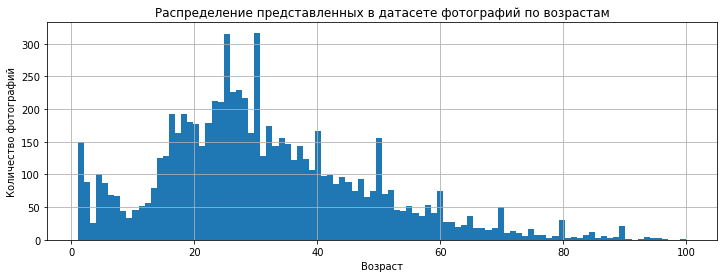

In [6]:
labels.hist(bins=100, figsize=(12, 4))
plt.title('Распределение представленных в датасете фотографий по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

- Большинсто фотографий принадлежит людям 17-35 лет. Соответственно, есть предположение, что именно их модель научится различать точнее. 
- Так же видим, что фотографий людей старше 60 достаточно мало, что может затруднить точную интерпретацию возраста для данных фотографий.
- Можем так же отметить пиковые значения некоторых возрастов: 1, 25, 30, 40, 50, 60, 70, 80 и 90 лет - возможно, возраст некоторых людей на фотографиях был прикинут "на глаз" при разметке датасета.

Используем загрузчик `ImageDataGenerator`. Из фотографий в папках класс ImageDataGenerator формирует батчи с изображениями и метками классов. Сделаем предобработку данных: поделим значения яркости на 255.

Чтобы загрузчик извлёк данные из папки, вызовем функцию `flow_from_directory()` 

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузчик обнаружил 7591 фотографий. Значение совпадает с количеством фотографий в датасете `labels` с метками. 

Сохраним в отдельные переменные сами фотографии и метки возраста для каждой фотографии.

In [8]:
features, target = next(train_gen_flow)

Рассмотрим, как выглядят массивы с данными.

In [9]:
features.shape, target.shape

((32, 224, 224, 3), (32,))

В батче 32 фотографии с разрешением 234х234 и тремя каналами (то есть цветных). Выведем эти фотографии из батча.

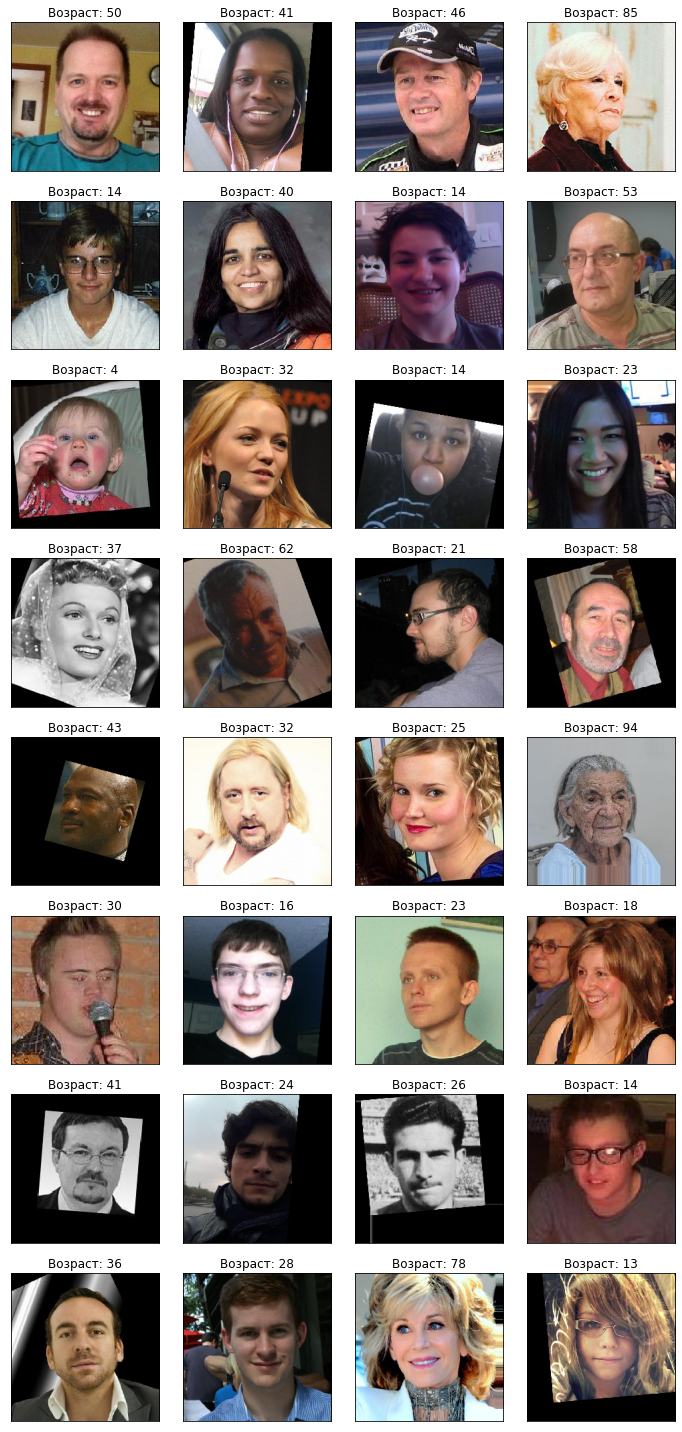

In [10]:
fig = plt.figure(figsize=(10, 20))
for i in range(32):
    fig.add_subplot(8, 4, i + 1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

- Датасет представлен различными фотографиями людей: афас, профиль и полубоком, повернутые и нет, цветные и черно-белые.
- Я плохо идентифицирую возраст людей, поэтому поверю в реалистичность указанных возрастов, хотя фотка предпоследней леди дает основания предположить, что ей не 78 лет.

## Обучение модели

Перенесём сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, НО(!) оформлен как ячейка с кодом, так как там всё равно только загрузка библиотек и функции, а смотрится куда лучше, чем текст)

Ниже представлены функции, которые были в дальнейшем отправлены в отдельный GPU-тренажёр. 

- `load_train` получает на вход путь с файлами и использует загрузчик `ImageDataGenerator` для создания тренировочного датасета из 75% фотографий. На них мы применяем аугментацию с вращением и сдвигами по ширине и высоте. 


- `load_test` в свою очередь получает на вход путь с файлами и использует загрузчик `ImageDataGenerator` для создания валидационного датасета из 25% фотографий, к которым аугментация не применяется.


- Для того, чтобы данные датасетов не перемешивались, выбрали одинаковый параметр `seed`.


- `create_model` создает модель на основе `ResNet50` без верхних слоев с использованием весов `'imagenet'`. На данный костяк мы добавили пулинг с окном во весь тензор `GlobalAveragePooling2D` и полносвязный слой для регрессии с одним нейроном. Для обучения нейронной сети мы указали функцию потерь `mean_square_error` - `mse` (так как было сказано, что она обучается быстрее), а для оценки метрики качетсва выбрали `mean absolute error`. В качестве оптимизатора взяли `Adam` c `learning_rate=0.001`.


- `train_model` принимает на вход модель, тренировочный и валидационный датасеты и параметры в виде размера батча и количества эпох. Так же в данной фукции был реализован класс `MyThresholdCallback` на основе `tensorflow.keras.callbacks.Callback`, который отслеживает значения метрики качества на валидационной выборке и позволяет остановить обучение при достижении желаемого значения метрики качества. В данной функции было выбрано значение `mae` на валидационной выборке ниже 6.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow



def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer,
                  metrics=['mae'])
    return model



def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=32,
                epochs=30, steps_per_epoch=None, validation_steps=None):

    class MyThresholdCallback(Callback):
        def __init__(self, threshold):
            super(MyThresholdCallback, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            mae = logs['val_mae']
            if mae <= self.threshold:
                self.model.stop_training = True

    callback = MyThresholdCallback(threshold=6)

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs=epochs,
              verbose=2,
              callbacks=[callback],
              shuffle=True
              )
    return model


Мы запустили код в отдельном GPU-тренажёре и получили следующий вывод на экран:

```
2023-02-12 03:13:49.309471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-02-12 03:13:49.517624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-02-12 03:13:54.002370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-12 03:13:54.677510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-12 03:13:54.677593: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:13:54.677625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:13:54.748383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-12 03:13:54.778447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-12 03:13:55.104960: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-12 03:13:55.147764: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-12 03:13:55.147872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-12 03:13:55.152392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-02-12 03:13:56.630938: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-02-12 03:13:56.663262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-02-12 03:13:56.665354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b9a20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-12 03:13:56.665371: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-12 03:13:56.846358: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53c2670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-12 03:13:56.846396: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-02-12 03:13:56.848818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-12 03:13:56.848878: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:13:56.848888: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:13:56.848925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-12 03:13:56.848937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-12 03:13:56.848947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-12 03:13:56.848956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-12 03:13:56.848964: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-12 03:13:56.853408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-02-12 03:13:56.855261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:14:00.237360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-12 03:14:00.237407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-02-12 03:14:00.237415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-02-12 03:14:00.241668: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-12 03:14:00.241719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 4s
  253952/94765736 [..............................] - ETA: 21s
 1941504/94765736 [..............................] - ETA: 5s 
 7528448/94765736 [=>............................] - ETA: 1s
15818752/94765736 [====>.........................] - ETA: 1s
23060480/94765736 [======>.......................] - ETA: 0s
31350784/94765736 [========>.....................] - ETA: 0s
39133184/94765736 [===========>..................] - ETA: 0s
46792704/94765736 [=============>................] - ETA: 0s
54583296/94765736 [================>.............] - ETA: 0s
62087168/94765736 [==================>...........] - ETA: 0s
70189056/94765736 [=====================>........] - ETA: 0s
77570048/94765736 [=======================>......] - ETA: 0s
85614592/94765736 [==========================>...] - ETA: 0s
92921856/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/30
2023-02-12 03:14:23.773937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:14:25.829695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 115s - loss: 253.2609 - mae: 11.3674 - val_loss: 941.3562 - val_mae: 25.8849
Epoch 2/30
178/178 - 88s - loss: 93.3863 - mae: 7.2740 - val_loss: 796.3485 - val_mae: 23.1305
Epoch 3/30
178/178 - 89s - loss: 74.1560 - mae: 6.5146 - val_loss: 354.0261 - val_mae: 14.0485
Epoch 4/30
178/178 - 89s - loss: 55.7648 - mae: 5.7194 - val_loss: 129.1789 - val_mae: 8.4934
Epoch 5/30
178/178 - 89s - loss: 45.6773 - mae: 5.2046 - val_loss: 134.0317 - val_mae: 9.0294
Epoch 6/30
178/178 - 88s - loss: 38.9086 - mae: 4.8352 - val_loss: 92.2780 - val_mae: 7.1560
Epoch 7/30
178/178 - 89s - loss: 34.3727 - mae: 4.5309 - val_loss: 82.6918 - val_mae: 6.6352
Epoch 8/30
178/178 - 88s - loss: 31.1324 - mae: 4.2975 - val_loss: 77.9897 - val_mae: 6.5651
Epoch 9/30
178/178 - 88s - loss: 26.7043 - mae: 4.0056 - val_loss: 87.9568 - val_mae: 7.0547
Epoch 10/30
178/178 - 88s - loss: 22.1105 - mae: 3.6565 - val_loss: 95.1919 - val_mae: 7.0631
Epoch 11/30
178/178 - 89s - loss: 20.7311 - mae: 3.5066 - val_loss: 68.2608 - val_mae: 6.1293
Epoch 12/30
178/178 - 89s - loss: 18.5216 - mae: 3.2925 - val_loss: 75.3238 - val_mae: 6.2774
Epoch 13/30
178/178 - 88s - loss: 16.7616 - mae: 3.1571 - val_loss: 77.0118 - val_mae: 6.5707
Epoch 14/30
178/178 - 88s - loss: 17.0408 - mae: 3.1841 - val_loss: 70.3066 - val_mae: 6.1931
Epoch 15/30
178/178 - 88s - loss: 15.8930 - mae: 3.0648 - val_loss: 86.7924 - val_mae: 6.7810
Epoch 16/30
178/178 - 88s - loss: 16.3681 - mae: 3.0807 - val_loss: 77.8267 - val_mae: 6.4602
Epoch 17/30
178/178 - 89s - loss: 13.5568 - mae: 2.8380 - val_loss: 76.3436 - val_mae: 6.5722
Epoch 18/30
178/178 - 88s - loss: 11.7027 - mae: 2.6314 - val_loss: 77.9159 - val_mae: 6.4033
Epoch 19/30
178/178 - 88s - loss: 11.1576 - mae: 2.5657 - val_loss: 64.0558 - val_mae: 5.9021
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 64.0558 - mae: 5.9021
Test MAE: 5.9021
```

Используя данную модель за 12 эпох мы достигли значения метрики качества `mae` в `5.90 лет` на валидационной выборке при значении в `2.56 лет` на тестовой выборке. 

Так же при аугментации изображений добавим параметр `horizontal_flip`, отвечающий за отражение фотографий в горизонтальной плоскости и посмотрим, как от этого изменится результат обучения модели. 

Код ниже полностью соответсвует уже использованному за исключением добавленного параметра.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow



def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer,
                  metrics=['mae'])
    return model



def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=32,
                epochs=30, steps_per_epoch=None, validation_steps=None):

    class MyThresholdCallback(Callback):
        def __init__(self, threshold):
            super(MyThresholdCallback, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            mae = logs['val_mae']
            if mae <= self.threshold:
                self.model.stop_training = True

    callback = MyThresholdCallback(threshold=6)

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs=epochs,
              verbose=2,
              callbacks=[callback],
              shuffle=True
              )
    return model

Мы запустили код в отдельном GPU-тренажёре и получили следующий вывод на экран:

```
2023-02-12 03:52:06.399592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-02-12 03:52:06.612576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-02-12 03:52:10.574079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-12 03:52:11.258534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-12 03:52:11.258616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:52:11.258648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:52:11.324306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-12 03:52:11.360078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-12 03:52:11.690548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-12 03:52:11.729137: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-12 03:52:11.729229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-12 03:52:11.733619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-02-12 03:52:13.107790: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-02-12 03:52:13.137800: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-02-12 03:52:13.139731: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x477a680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-12 03:52:13.139762: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-12 03:52:13.320439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46b4db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-12 03:52:13.320475: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-02-12 03:52:13.322851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-12 03:52:13.322908: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:52:13.322919: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:52:13.322946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-12 03:52:13.322956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-12 03:52:13.322966: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-02-12 03:52:13.322976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-02-12 03:52:13.322984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-12 03:52:13.327212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-02-12 03:52:13.329058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 03:52:16.999529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-12 03:52:16.999588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-02-12 03:52:16.999596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-02-12 03:52:17.004099: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-12 03:52:17.004153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 27s
   98304/94765736 [..............................] - ETA: 52s
  557056/94765736 [..............................] - ETA: 18s
 2310144/94765736 [..............................] - ETA: 6s 
 4202496/94765736 [>.............................] - ETA: 4s
 8396800/94765736 [=>............................] - ETA: 3s
11329536/94765736 [==>...........................] - ETA: 3s
12591104/94765736 [==>...........................] - ETA: 3s
14016512/94765736 [===>..........................] - ETA: 4s
15458304/94765736 [===>..........................] - ETA: 4s
16785408/94765736 [====>.........................] - ETA: 4s
18210816/94765736 [====>.........................] - ETA: 4s
19652608/94765736 [=====>........................] - ETA: 4s
20979712/94765736 [=====>........................] - ETA: 4s
22405120/94765736 [======>.......................] - ETA: 4s
23846912/94765736 [======>.......................] - ETA: 4s
25174016/94765736 [======>.......................] - ETA: 4s
26599424/94765736 [=======>......................] - ETA: 4s
28041216/94765736 [=======>......................] - ETA: 4s
29368320/94765736 [========>.....................] - ETA: 4s
30793728/94765736 [========>.....................] - ETA: 4s
32235520/94765736 [=========>....................] - ETA: 4s
33562624/94765736 [=========>....................] - ETA: 4s
35004416/94765736 [==========>...................] - ETA: 4s
36446208/94765736 [==========>...................] - ETA: 4s
37756928/94765736 [==========>...................] - ETA: 4s
38756352/94765736 [===========>..................] - ETA: 4s
39772160/94765736 [===========>..................] - ETA: 3s
40787968/94765736 [===========>..................] - ETA: 3s
41639936/94765736 [============>.................] - ETA: 3s
41951232/94765736 [============>.................] - ETA: 4s
42655744/94765736 [============>.................] - ETA: 4s
42737664/94765736 [============>.................] - ETA: 4s
43212800/94765736 [============>.................] - ETA: 4s
43556864/94765736 [============>.................] - ETA: 4s
43900928/94765736 [============>.................] - ETA: 4s
44244992/94765736 [=============>................] - ETA: 4s
44589056/94765736 [=============>................] - ETA: 4s
44949504/94765736 [=============>................] - ETA: 4s
45293568/94765736 [=============>................] - ETA: 4s
45637632/94765736 [=============>................] - ETA: 4s
45981696/94765736 [=============>................] - ETA: 4s
46145536/94765736 [=============>................] - ETA: 4s
46489600/94765736 [=============>................] - ETA: 4s
46833664/94765736 [=============>................] - ETA: 4s
47177728/94765736 [=============>................] - ETA: 4s
47538176/94765736 [==============>...............] - ETA: 4s
47882240/94765736 [==============>...............] - ETA: 5s
48242688/94765736 [==============>...............] - ETA: 5s
48586752/94765736 [==============>...............] - ETA: 5s
48947200/94765736 [==============>...............] - ETA: 5s
49307648/94765736 [==============>...............] - ETA: 5s
49668096/94765736 [==============>...............] - ETA: 5s
50028544/94765736 [==============>...............] - ETA: 5s
50339840/94765736 [==============>...............] - ETA: 5s
50700288/94765736 [===============>..............] - ETA: 5s
51060736/94765736 [===============>..............] - ETA: 5s
51421184/94765736 [===============>..............] - ETA: 5s
51798016/94765736 [===============>..............] - ETA: 5s
52174848/94765736 [===============>..............] - ETA: 5s
52535296/94765736 [===============>..............] - ETA: 5s
52912128/94765736 [===============>..............] - ETA: 5s
53288960/94765736 [===============>..............] - ETA: 5s
53665792/94765736 [===============>..............] - ETA: 5s
54042624/94765736 [================>.............] - ETA: 5s
54435840/94765736 [================>.............] - ETA: 5s
54534144/94765736 [================>.............] - ETA: 5s
54910976/94765736 [================>.............] - ETA: 5s
55287808/94765736 [================>.............] - ETA: 5s
55681024/94765736 [================>.............] - ETA: 5s
56074240/94765736 [================>.............] - ETA: 5s
56451072/94765736 [================>.............] - ETA: 5s
56844288/94765736 [================>.............] - ETA: 5s
57237504/94765736 [=================>............] - ETA: 5s
57630720/94765736 [=================>............] - ETA: 5s
58023936/94765736 [=================>............] - ETA: 5s
58417152/94765736 [=================>............] - ETA: 5s
58728448/94765736 [=================>............] - ETA: 5s
59121664/94765736 [=================>............] - ETA: 5s
59514880/94765736 [=================>............] - ETA: 5s
59908096/94765736 [=================>............] - ETA: 5s
60317696/94765736 [==================>...........] - ETA: 5s
60710912/94765736 [==================>...........] - ETA: 5s
61120512/94765736 [==================>...........] - ETA: 5s
61530112/94765736 [==================>...........] - ETA: 4s
61923328/94765736 [==================>...........] - ETA: 4s
62332928/94765736 [==================>...........] - ETA: 4s
62742528/94765736 [==================>...........] - ETA: 4s
62922752/94765736 [==================>...........] - ETA: 4s
63315968/94765736 [===================>..........] - ETA: 4s
63725568/94765736 [===================>..........] - ETA: 4s
64135168/94765736 [===================>..........] - ETA: 4s
64544768/94765736 [===================>..........] - ETA: 4s
64954368/94765736 [===================>..........] - ETA: 4s
65363968/94765736 [===================>..........] - ETA: 4s
65773568/94765736 [===================>..........] - ETA: 4s
66199552/94765736 [===================>..........] - ETA: 4s
66609152/94765736 [====================>.........] - ETA: 4s
67018752/94765736 [====================>.........] - ETA: 4s
67117056/94765736 [====================>.........] - ETA: 4s
67526656/94765736 [====================>.........] - ETA: 4s
67936256/94765736 [====================>.........] - ETA: 4s
68345856/94765736 [====================>.........] - ETA: 4s
68771840/94765736 [====================>.........] - ETA: 4s
69181440/94765736 [====================>.........] - ETA: 4s
69591040/94765736 [=====================>........] - ETA: 4s
70017024/94765736 [=====================>........] - ETA: 4s
70426624/94765736 [=====================>........] - ETA: 4s
70836224/94765736 [=====================>........] - ETA: 4s
71262208/94765736 [=====================>........] - ETA: 3s
71311360/94765736 [=====================>........] - ETA: 3s
71720960/94765736 [=====================>........] - ETA: 3s
72146944/94765736 [=====================>........] - ETA: 3s
72556544/94765736 [=====================>........] - ETA: 3s
72982528/94765736 [======================>.......] - ETA: 3s
73146368/94765736 [======================>.......] - ETA: 3s
73441280/94765736 [======================>.......] - ETA: 3s
73736192/94765736 [======================>.......] - ETA: 3s
74014720/94765736 [======================>.......] - ETA: 3s
74309632/94765736 [======================>.......] - ETA: 3s
74604544/94765736 [======================>.......] - ETA: 3s
74899456/94765736 [======================>.......] - ETA: 3s
75194368/94765736 [======================>.......] - ETA: 3s
75489280/94765736 [======================>.......] - ETA: 3s
75505664/94765736 [======================>.......] - ETA: 3s
75800576/94765736 [======================>.......] - ETA: 3s
76095488/94765736 [=======================>......] - ETA: 3s
76390400/94765736 [=======================>......] - ETA: 3s
76685312/94765736 [=======================>......] - ETA: 3s
76980224/94765736 [=======================>......] - ETA: 3s
77275136/94765736 [=======================>......] - ETA: 3s
77586432/94765736 [=======================>......] - ETA: 3s
77881344/94765736 [=======================>......] - ETA: 3s
78192640/94765736 [=======================>......] - ETA: 3s
78503936/94765736 [=======================>......] - ETA: 3s
78798848/94765736 [=======================>......] - ETA: 3s
79110144/94765736 [========================>.....] - ETA: 2s
79421440/94765736 [========================>.....] - ETA: 2s
79699968/94765736 [========================>.....] - ETA: 2s
80011264/94765736 [========================>.....] - ETA: 2s
80322560/94765736 [========================>.....] - ETA: 2s
80633856/94765736 [========================>.....] - ETA: 2s
80961536/94765736 [========================>.....] - ETA: 2s
81272832/94765736 [========================>.....] - ETA: 2s
81600512/94765736 [========================>.....] - ETA: 2s
81928192/94765736 [========================>.....] - ETA: 2s
82239488/94765736 [=========================>....] - ETA: 2s
82567168/94765736 [=========================>....] - ETA: 2s
82894848/94765736 [=========================>....] - ETA: 2s
83222528/94765736 [=========================>....] - ETA: 2s
83566592/94765736 [=========================>....] - ETA: 2s
83894272/94765736 [=========================>....] - ETA: 2s
84221952/94765736 [=========================>....] - ETA: 2s
84549632/94765736 [=========================>....] - ETA: 2s
84893696/94765736 [=========================>....] - ETA: 1s
85237760/94765736 [=========================>....] - ETA: 1s
85565440/94765736 [==========================>...] - ETA: 1s
85909504/94765736 [==========================>...] - ETA: 1s
86253568/94765736 [==========================>...] - ETA: 1s
86597632/94765736 [==========================>...] - ETA: 1s
86941696/94765736 [==========================>...] - ETA: 1s
87269376/94765736 [==========================>...] - ETA: 1s
87613440/94765736 [==========================>...] - ETA: 1s
87973888/94765736 [==========================>...] - ETA: 1s
88088576/94765736 [==========================>...] - ETA: 1s
88432640/94765736 [==========================>...] - ETA: 1s
88776704/94765736 [===========================>..] - ETA: 1s
89120768/94765736 [===========================>..] - ETA: 1s
89464832/94765736 [===========================>..] - ETA: 1s
89808896/94765736 [===========================>..] - ETA: 1s
90169344/94765736 [===========================>..] - ETA: 0s
90513408/94765736 [===========================>..] - ETA: 0s
90857472/94765736 [===========================>..] - ETA: 0s
91217920/94765736 [===========================>..] - ETA: 0s
91561984/94765736 [===========================>..] - ETA: 0s
91922432/94765736 [============================>.] - ETA: 0s
92266496/94765736 [============================>.] - ETA: 0s
92282880/94765736 [============================>.] - ETA: 0s
92626944/94765736 [============================>.] - ETA: 0s
92971008/94765736 [============================>.] - ETA: 0s
93331456/94765736 [============================>.] - ETA: 0s
93691904/94765736 [============================>.] - ETA: 0s
94035968/94765736 [============================>.] - ETA: 0s
94396416/94765736 [============================>.] - ETA: 0s
94740480/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 20s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/30
2023-02-12 03:52:59.411068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-12 03:53:01.460582: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 115s - loss: 260.2041 - mae: 11.5739 - val_loss: 473.7807 - val_mae: 16.6896
Epoch 2/30
178/178 - 89s - loss: 100.5651 - mae: 7.5896 - val_loss: 844.2016 - val_mae: 24.1666
Epoch 3/30
178/178 - 89s - loss: 80.6213 - mae: 6.8011 - val_loss: 298.3557 - val_mae: 12.6947
Epoch 4/30
178/178 - 88s - loss: 66.1700 - mae: 6.2109 - val_loss: 127.8259 - val_mae: 8.3468
Epoch 5/30
178/178 - 88s - loss: 57.4077 - mae: 5.7773 - val_loss: 80.2310 - val_mae: 6.6476
Epoch 6/30
178/178 - 88s - loss: 49.6502 - mae: 5.4045 - val_loss: 70.6698 - val_mae: 6.2154
Epoch 7/30
178/178 - 89s - loss: 45.0158 - mae: 5.1229 - val_loss: 75.1913 - val_mae: 6.5203
Epoch 8/30
178/178 - 89s - loss: 39.6709 - mae: 4.8914 - val_loss: 76.1263 - val_mae: 6.3828
Epoch 9/30
178/178 - 89s - loss: 37.7221 - mae: 4.7305 - val_loss: 76.7814 - val_mae: 6.4250
Epoch 10/30
178/178 - 89s - loss: 33.2926 - mae: 4.4641 - val_loss: 66.9159 - val_mae: 5.9440
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 66.9159 - mae: 5.9440
Test MAE: 5.9440
```

Добавление к методам аугментации **горизонтального отражения** позволило добиться метрики качества **`mae` менее 6 лет** на валидационной выборке **за 10 эпох**, при этом `mae` на тренировочной выборке оказалось `4.46`. По сравнению с предыдущей, **модель переобучилась чуть меньше** и достигла желаемого значения метрики качества за чуть меньшее количество эпох. 

Ввиду близких значений `mae` на валидационной выборке было решено остановиться на менее переученной модели с горизонтальным отражением.

## Анализ обученной модели

За **10 эпох** при размере **батча в 32 фотографии** нам удалось добиться **метрики качества `mae` на валидационной выборке в `6 лет`** при `mae` на тренировочной в `4.46 года`. Данные значения говорят о небольшой переученности модели, но известно, что модели с большим числом слоев сильно переобучаются.

Напомним, что сетевой супермаркет "Хлеб-Соль" хочет использовать фотофиксацию в прикассовой зоне чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. С данной задачей модель должна справиться - **`mae` в пределах 6 лет позволит предлагать товары для схожей возрастной категории**.  


- Контролировать добросовестность кассиров при продаже алкоголя. С данным пунктом гораздо сложнее, так как продажа алкоголя начинается всегда с определенного возраста, и ошибок быть не должно. Так как некоторые люди выглядят то моложе, то старше своего возраста, опираться на модель с точностью определения возраста в несколько лет является недопустимым, так что **модель* рекомендовалось бы использовать **в качестве вспомогательного средства** при проверке возраста покупателя.

Таким образом модель с метрикой качества `mae` на валидационной выборке в `6 лет` должна справиться с поставленными задачами.